## Temps de vie du muon

### Simulation via la méthode de MonteCarlo

Avant d'analyser nos données, nous avons commencé par faire une simulation de notre problème et nous avons pour cela généré aléatoirement des temps de vie.
Une fois nos valeurs générées, nous avons implémenté une fonction qui a la forme attendue et qui va ajuster au mieux nos valeurs. Dans notre cas on s'attend à ce que la fonction de distribution de probabilité suit une loi exponentielle. 

$$ pdf = \frac{k}{\tau} e^{-t/\tau}$$

où $k/\tau$ correspond au facteur de normalisation

Il existe deux façons d'appliquer la simulation de MonteCarlo, on peut soit utiliser la méthode de *Hit & Miss* , soit la méthode de *Inverse Sampling*. Dans la méthode de *Hit & Miss*, parmi toutes nos valeurs générées on ne garde que celles qui se trouvent en dessous de la courbe attendue. Or comme dans notre cas on s'attend à avoir une exponentielle décroissante, on perderait beaucoup de temps à parcourir plus de 50% des valeurs qui seront un "miss"; c'est pourquoi on a utilisé la méthode de *Inverse Sampling*. Cette méthode utilise directement la fonction de répartition de nos données et utilise ses propriétés, mais pour cela il faut que la fonction soit inversible, ce qui est le cas de l'exponentielle. 

#### Inverse Sampling

Soit une fonction de distribution exponentielle g: 
\begin{array}{rlcl}
&g(x) &=&\frac{k}{\tau}  e^{-x/\tau} \\
\Rightarrow &g(x)dx&= &f(\xi)d\xi
\end{array}
avec $\xi=\xi(x)$

On choisit $\xi$ tel qu'il soit réparti uniformémement entre 0 et 1, ainsi $f(\xi)=1$.

On a alors que $$g(x) = 1 \frac{d\xi}{dx}$$
Or $$\xi = G(x) => G^{-1}(\xi) = x$$ 

$$=> g(x) = \frac{dG(x)}{dx} => G(x) = \int^x_0 g(y)dy$$
Ainsi dans notre cas on aura, pour $\xi = G(G^{-1}(\xi))$:

\begin{array}{rlcl}
&\xi &=& \int^{G^{-1}(\xi)}_0 \frac{k}{\tau} e^{-x/\tau}dx \\
&\xi &=& -k(e^{-G^{-1}(\xi)/tau}-1)\\
\Rightarrow &G^{-1}(\xi)&=& -\tau \ln(-\xi+1)
\end{array}

Et pour nous $x=G^{-1}(\xi)$ corespondera aux différentes valeurs de temps.

In [1]:
import numpy as np
import scipy as sp

%matplotlib inline 
import matplotlib.pyplot as plt

Comme nous avons choisi de ne prendre nos données qu'à partir de $500 \pm 4 ns$, afin d'éviter les starts-stops et que nous n'avons pas pris des valeurs au-dessus de $20\mu s$, nous devrons aussi générer nos valeurs de $\tau$ uniquement dans cette fenêtre de temps. D'après l'oscilloscope nous ne devrions pas avoir de valeurs au-dessus de $16.5 \pm 0.4 \mu s$, mais comme on l'a vu le TDC mesure toujours un temps légerement supérieur à celui de l'oscilloscope c'est pourquoi on prendra comme limite supérieur $20 \mu s$.

In [2]:
#début et fin de la fenêtre de temps

t_start=500     #en ns car nos données seront en ns
t_stop=20000    #en ns
tau_v=2200      #temps de vie "théorique" en ns
mc_events=10000   #nombre d'évenements que nous allons généré


N.B. Toutes les valeurs de temps seront exprimées en $ns$ dans la suite du notebook.

In [3]:
#definition d'une fonction exponentielle qcq (utile pour le fit)
def exp_decay(x, k, t, y0):
    return k * ((1/t) *np.exp(-x / t) + y0)

#def de notre G^-1
def inv(t):
    return -tau_v*np.log(-t+1)

#comme nous voudrons donner toute une série de t diff à notre fct, il faut la vectoriser
vect_inv=np.vectorize(inv)

In [4]:
#on génère nos nombres 
rnd1 = np.random.rand(mc_events)

In [5]:
data=vect_inv(rnd1)  #on calcul nos x=tau
index1=np.where((t_start<data) & (t_stop>data ))  #on se restreint pour mieux simuler les valeurs qu'on aura expérimentalement
data1=data[index1]

**Graphique des données générées aléatoirements**

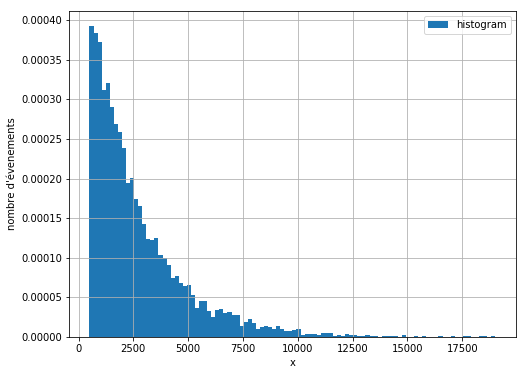

In [6]:
fig2, ax2 = plt.subplots(figsize=(8,6))
plt.grid()
ax2.hist(data1, bins = 100, normed = True, label='histogram')
ax2.set_xlabel("x")
ax2.set_ylabel("nombre d'évenements")
ax2.legend()
plt.show()

#### Maximum de vraisemblance

Maintenant que nous avons des données, on aimerait trouver la meilleure estimation de nos données; c'est-à-dire la courbe esponentielle qui suit le mieux nos données. 

Pour cela nous avons décidé d'utiliser la méthode du maximum de vraisemblance. Cette méthode consiste à maximiser le produit des fonctions de distribution de probabilités de nos évenements:
$$L = \prod_{i=1}^N  pdf(evt_i)$$

Afin de faciliter les calculs on prend le logarithme de cette fonction, ce qui nous permet de transformer le produit en une somme.

Pour $pdf = f(t/\tau)=\frac{k}{\tau} e^{-t/\tau}$ on trouve la constante k par normalisation:

$$\int^{t_{max}}_{t_{min}} f(t/\tau) dt =1 => k = \frac{1}{(e^{-t_{min}/\tau}-e^{-t_{max}/\tau})}$$

$$L^* = - \ln(L) = N\ln(\tau) + N\ln(e^{-t_{min}/\tau}-e^{-t_{max}/\tau})+1/\tau \sum^N_{i=1} t_i$$

Comme il fallait maximiser $L$, il faudra minimiser $L^*$.

In [7]:
n= len(index1[0])

#définition de L_star
#on itère sur le nombre de donnée pour calculer la somme du dernier terme de L_star
def L_star(tau, t_start, t_stop):
    S=0
    for i in range(n):
        if data1[i]>t_start and data1[i]<t_stop:
            S=S+data1[i]
    return n*np.log(tau)+n*np.log(np.exp(-t_start/tau)-np.exp(-t_stop/tau))+1/tau*S

#on vectorise notre fonction
L_vect=np.vectorize(L_star) 

In [8]:
vect_tau=np.linspace(t_start,t_stop,1000)   #on crée un vecteur quelconque avec un tau qui est compris entre notre t_start et t_stop
t_start_vect=t_start*np.ones_like(vect_tau)  #on vectorise t_start et t_stop pour pouvoir les donner comme arguments à L_vect
t_stop_vect=t_stop*np.ones_like(vect_tau)
L_vect2=L_vect(vect_tau, t_start_vect, t_stop_vect)   #on évalue notre L_star en tout ces vecteurs

Maintenant qu'on a un vecteur avec toutes les valeurs de $L^*$ pour des $\tau$ compris dans l'intervalle désiré, on peut trouver le $L^*$ minimum et ensuite trouver le $\tau$ correspondant. On aura ainsi trouver le $\tau$ qui minimise notre fonction, ce $\tau$ correspondera au temps de vie du muon.

In [9]:
L_min=min(L_vect2)
def min_tau(L_vect2, L_min, vect_tau):
    ind =0
    for i in range(1000):         #on cherche l'indice associé à sa position
        if (L_vect2[i]==L_min):
            ind=i
    tau_min=vect_tau[ind] 
    return tau_min


print(min_tau(L_vect2, L_min, vect_tau), 'ns')

2256.75675676 ns


Notre simulation nous donne donc un temps de vie très proche de $2.2 \mu s$. (la valeur varie légèremenet à chaque compilation, étant donné que nos valeurs générées aléatoirements ne sont jamais exactement les mêmes.)

**erreur sur les variables**

Si on regarde notre L proche du minimum, sa fonction suivra une gaussiènne et donc, si on regarde notre courbe Likelihood, courbe de $L^*$ en fonction de $\tau$, on remarque que celle-ci a une forme parabolique. Plaçons nous donc à une petite distance du minimum et regardons que vaut cette erreur.

Soit $\overline{\theta}=\theta_v = \text{vrai valeur}$, $\hat{\theta}  = \text{valeur estimée}$ et $\sigma = \text{erreur sur theta}$.

On aura donc $$ L(\hat{\theta}) = \frac{1}{\sqrt{2\pi}\sigma}
e^{-\frac{(\hat{\theta}-\overline{\theta})^2}{\sigma^2}}$$

$$L^*=-\ln{L(\hat{\theta})}=0.5\ln{(2\pi\sigma^2)}+0.5\frac{(\hat{\theta}-\overline{\theta})^2}{\sigma^2}$$

$$L^*_{min}(\hat{\theta}=\overline{\theta})=\frac{1}{2}\ln{(2\pi\sigma^2)}$$
$$L^*(\hat{\theta}=\overline{\theta}+\sigma)=L^*_{min}+\frac{1}{2}$$
On peut maintenant regarder notre courbe Likelihood, afin de mieux visualiser l'erreur sur les variables.

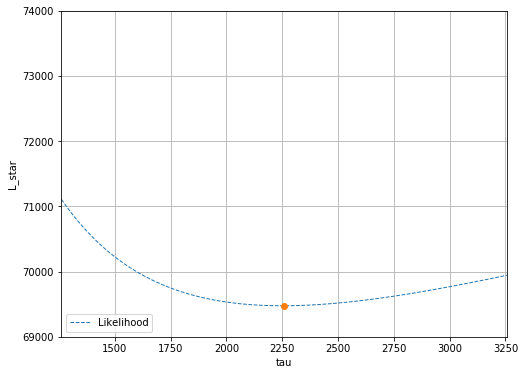

In [10]:
fig3, ax3 = plt.subplots(figsize=(8,6))
plt.grid()
ax3.plot(vect_tau, L_vect2, '--', lw=1, label="Likelihood")
ax3.plot(min_tau(L_vect2, L_min, vect_tau), L_min,'o', ms=6)
ax3.set_xlabel("tau")
ax3.set_ylabel("L_star")
ax3.legend()
ax3.set_xlim(min_tau(L_vect2, L_min, vect_tau)-1000, min_tau(L_vect2, L_min, vect_tau)+1000)
ax3.set_ylim(69000, 74000)
plt.show()

In [11]:
#cette fonction nous permet de trouver la valeur de L_star la plus proche de L_min+1/2
#la différence entre le tau minimal et le tau correspondant à ce nouveau L_star est l'erreur
def t_demi(L_vect2,t_start, t_stop, L_min, vect_tau):
    tau2=min_tau(L_vect2, L_min, vect_tau)
    for i in range(1,10000):
        tau2=tau2+0.1
        if L_star(tau2,t_start,t_stop)>L_min+0.5:
            break
    return tau2

In [12]:
print(t_demi(L_vect2, t_start, t_stop, L_min, vect_tau))
print(t_demi(L_vect2, t_start, t_stop, L_min, vect_tau)-min_tau(L_vect2, L_min, vect_tau))

2276.65675676
19.9


On aimerait maintenant voir sur un graphique si la courbe exponentielle est bien une bonne approximation de nos valeurs.
Mais avant cela il nous faut déterminer notre constante de normalisation k.

$$1=\int^{t_{max}}_{t_{min}} \frac{k}{\tau}e^{-t/\tau}dt$$

$$k= \frac{-1}{e^{-t_{max}/\tau}-e^{-t_{min}/\tau}}$$

In [13]:
def norm(t_start, t_stop, L_vect2):
    k=-1/(np.exp(-t_stop/min_tau(L_vect2, L_min, vect_tau))-np.exp(-t_start/min_tau(L_vect2, L_min, vect_tau)))
    return k

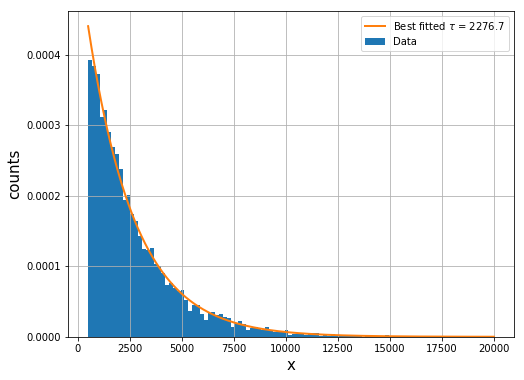

In [14]:
fig2, ax2 = plt.subplots(figsize=(8,6))
plt.grid()
ax2.hist(data1,bins = 100,normed=True, label="Data")
x = np.arange(t_start, t_stop, 0.1)

ax2.plot(x, exp_decay(x, norm(t_start, t_stop, L_vect2), t_demi(L_vect2, t_start, t_stop, L_min, vect_tau), 0), lw =2 , label=r"Best fitted $\tau$ = %.1f"%t_demi(L_vect2, t_start, t_stop, L_min, vect_tau))

ax2.set_xlabel("x", fontsize=15)
ax2.set_ylabel("counts", fontsize=15)
ax2.legend()
plt.show()

### Utilisation des données

Maintenant que nous avons notre code pour trouver la courbe qui ajuste au mieu les données, on va pouvoir appliquer le tout à nos données expérimentales.

In [15]:
#on a choisit une gamme de temps où on a le plus de chance de mesuré le temps de vie du muon
t_min=600    #on commence un peu après pour éviter le premier barreau
t_max=15000

In [16]:
#on importe nos données

file = open("C:/Users/noemi/Desktop/Data_last.txt")
nbins = 0
lines = file.readlines()
hist = []
for line in lines:
    line = line.replace('\r\n','')
    line = line.replace('\t','')
    try:
        hist.append(float(line.replace('\n', '')))
        nbins += 1
    except Exception as e:
        print (e)
        print (r"Line number: \"%s\" cannot be converted to integer" %(line))
        
file.close()

Comme nos données se trouvent sous forme d'une liste, alors que nos codes s'appliquent à des vecteurs, on transforme notre liste en vecteur.

D'autre part il se peut qu'on ait des données négatives, or celle-ci vont fausser notre histogramme, on doit donc restreindre les données utilisées aux valeurs positives.

(Nous n'avons pas réussi à trouver pourquoi il y avait ces valeurs négatives)

En définissant notre fonction L_star, nous lui avons donné comme arguments (tau, t_start, t_stop), afin d'avoir une fonction la plus général possible il aurait était idéal de lui donner aussi n et data1 comme arguments. Malheureusement à cause du fait q'on vectorise L_star nous n'avons pas réussi à le faire.

In [17]:
data_vector=np.array(hist)   #passage de list à vecteur de nos données

real_data=data_vector[np.where(data_vector>0)]    #on choisi uniquement les valeurs positives
n=len(real_data)
data1=real_data

Maintenant qu'on a nos données on va réutiliser les fonctions définies plus haut afin de trouver la courbe Likelihood et la valeur du temps de vie.

In [18]:
vect_tau2=np.linspace(t_min, t_max, 1000)

In [19]:
t_min_vect=t_min*np.ones_like(vect_tau2)
t_max_vect=t_max*np.ones_like(vect_tau2)
L_vect_data=L_vect(vect_tau2, t_min_vect, t_max_vect)   #calcul de L_star pour toute une série de tau

In [20]:
L_min_data=min(L_vect_data)    #L_star minimal
print(L_min_data)
min_tau_data=min_tau(L_vect_data, L_min_data, vect_tau2)   #valeur de tau qui minimise L_star
print(min_tau_data, 'ns')

6700.18194793
2113.51351351 ns


In [21]:
print(t_demi(L_vect_data, t_min, t_max, L_min_data, vect_tau2), 'ns')
print(t_demi(L_vect_data, t_min, t_max, L_min_data, vect_tau2)-min_tau(L_vect_data, L_min_data, vect_tau2),'ns')

2188.81351351 ns
75.2999999999 ns


L'erreur qu'on trouve est beaucoup trop petite et ne permet pas d'avoir le vrai temps de vie dans la marge d'erreur.

**Graphique**

Regardons comment la courbe ajuste nos données:

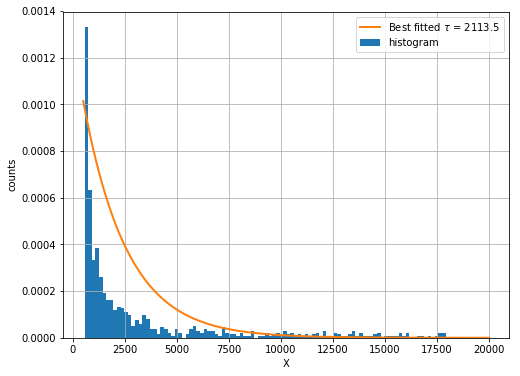

In [22]:
fig2, ax2 = plt.subplots(figsize=(8,6))
plt.grid()
ax2.hist(real_data, bins =100, normed = True, label='histogram')
x = np.arange(t_start, t_stop, 0.1)
ax2.plot(x, exp_decay(x, norm(t_start, t_stop, L_vect_data), min_tau_data, 0), lw =2 , label=r"Best fitted $\tau$ = %.1f"%min_tau_data)
#ax2.set_yscale('log')
ax2.set_xlabel("X")
ax2.set_ylabel("counts")
ax2.legend()
plt.show()

### Bruit

Jusqu'à là nous avons traité nos données comme si elles étaient purs, or nous savons qu'il y a un bruit électronique non négligeable.

Comme on sait que le temps de vie du muon est de $2.2 \mu s$, on peut s'attendre à ce que la queue de l'exponentielle n'est constituée que de bruit. Dans cette région le bruit semble se répartir uniformément et on pourrait donc l'assimiler à une droite. Mais comme on a plus de probabilité de mesurer du bruit au début de la gate, on aura plus d'événements correspondant au bruit dans cette région.
En effet comme le bruit est aléatoire la probabilité, que l'intervalle séparant deux événements bruits suceptibles de déclencher un signal start et stop soit petit, est grande.
Par conséquent le bruit sera en vérité aussi distribué selon une exponentielle décroissante, mais une esponentielle plus plâte que celle correspondant au temps de vie des muons. 

Il va donc falloir tenir compte de cela dans la fonction de distribution et on aura: 
$$fdp = k(\frac{1}{\tau}e^{-t/\tau}+y_0)$$

La constante de bruit correspond à la *"hauteur"* moyenne des colonnes dans la région considérée, elle sera égal au nombre d'évenements de bruit par unité de temps, le tout divisé par le nombre total d'événements: $$ y_0=\frac{\#bruit}{\Delta t_{bruit}\cdot \#év_{tot}}$$

Il va falloir aussi normaliser notre fonction de distribution:
\begin{array}{rlcl}
&\int^{t_{max}}_{t_{min}} k(\frac{1}{\tau}e^{-t/\tau}+y_0)dt &=& 1\\
& k \left( -(e^{-t_{max}/\tau}-e^{-t_min/\tau})+y_0(t_{max}-t_{min}) \right) &=&1 \\
\Leftrightarrow & k &=& \frac{1}{y_0(t_{max}-t_{min})-(e^{-t_{max}/\tau}-e^{-t_{min}/\tau})} 
\end{array}

On a considéré qu'à partir $15000  ns$ jusqu'à la fin le bruit domine complètement.

In [23]:
#bruit de 15000 à 17911
debut_bruit = 15000
t_bruit=real_data[np.where(real_data>debut_bruit)]
nb_bruit=len(t_bruit)  # #bruit

In [24]:
# delta t_bruit correspond à la durée de temps sur laquelle on a du bruit: fin_bruit-debut_bruit
fin_bruit=max(real_data)
y0 = nb_bruit/((fin_bruit-debut_bruit)*len(real_data))

print(y0)

9.31064639163e-06


In [25]:
k_bruit=1/(y0*(t_stop-t_start)-(np.exp(-t_stop/min_tau_data)-np.exp(-t_start/min_tau_data)))

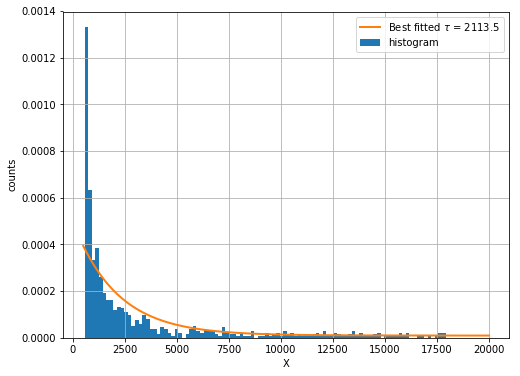

In [26]:
fig2, ax2 = plt.subplots(figsize=(8,6))
plt.grid()
ax2.hist(real_data, bins =100, normed = True, label='histogram')
x2= np.arange(t_start, t_stop, 0.1)
ax2.plot(x2, exp_decay(x2, k_bruit, min_tau_data, y0), lw =2 , label=r"Best fitted $\tau$ = %.1f"%min_tau_data)
#ax2.set_yscale('log')
ax2.set_xlabel("X")
ax2.set_ylabel("counts")
ax2.legend()
plt.show()

On remarque que cette courbe colle déjà beaucoup mieux à nos données et est donc une bien meuilleure approximation.